# xgboost

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import datetime
import re

In [2]:
###データ読込(結合したデータ)
train = pd.read_csv("~/repo/study/JLeague/data/train_new3.csv")
test = pd.read_csv("~/repo/study/JLeague/data/test_new3.csv")
player = pd.read_csv("~/repo/study/JLeague/data/player.csv")
test_id = pd.read_csv("~/repo/study/JLeague/motodata/test.csv")["id"]
test_id_all = test["id"]

## Feature Enginiering

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1952 entries, 0 to 1951
Data columns (total 43 columns):
id             1952 non-null int64
y              1952 non-null int64
year           1952 non-null int64
stage          1952 non-null object
match          1952 non-null object
gameday        1952 non-null object
time           1952 non-null object
home           1952 non-null object
away           1952 non-null object
stadium        1952 non-null object
tv             1952 non-null object
home_score     1952 non-null int64
away_score     1952 non-null int64
weather        1952 non-null object
temperature    1952 non-null float64
humidity       1952 non-null object
referee        1952 non-null object
home_team      1952 non-null object
home_01        1952 non-null object
home_02        1952 non-null object
home_03        1952 non-null object
home_04        1952 non-null object
home_05        1952 non-null object
home_06        1952 non-null object
home_07        1952 non-null obje

In [4]:
def j2num(j):
    return 1 if j == 'Ｊ１' else 0
train["stage"] = train["stage"].map(j2num)
test["stage"] = test["stage"].map(j2num)

In [5]:
for i, weather in enumerate(train["weather"]):
    weather = str(weather)
    if re.match("雨", weather):
        train.ix[i, "rain"] = 1
    else:
        train.ix[i, "rain"] = 0
for i, weather in enumerate(test["weather"]):
    weather = str(weather)
    if re.match("雨", weather):
        test.ix[i, "rain"] = 1
    else:
        test.ix[i, "rain"] = 0

/home/tsu-nera/anaconda3/envs/opt/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
/home/tsu-nera/anaconda3/envs/opt/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':


In [6]:
for i, m in enumerate(train["match"]):
    match = re.findall("第(\w+)節第(\w+)日", str(m))[0]
    train.ix[i, "match2"] = int(match[0])
    train.ix[i, "match3"] = int(match[1])
for i, m in enumerate(test["match"]):
    match = re.findall("第(\w+)節第(\w+)日", str(m))[0]
    test.ix[i, "match2"] = int(match[0])
    test.ix[i, "match3"] = int(match[1])

In [7]:
for i, tv in enumerate(train["tv"]):
    tv = str(tv)
    tvlist = tv.split("／")
    train.ix[i, "media"] = int(len(tvlist))
for i, tv in enumerate(test["tv"]):
    tv = str(tv)
    tvlist = tv.split("／")
    test.ix[i, "media"] = int(len(tvlist))

In [8]:
for i, day in enumerate(train["gameday"]):
    day = str(day)
    train.ix[i, "month"] = int(day[:2])
    train.ix[i, "day"] = int(day[3:5])
    weekday = day[5:]
    if re.match("\(\w・祝\)", weekday):
        train.ix[i, "weekday"] = 0
    elif re.match("\(\w・休\)", weekday):
        train.ix[i, "weekday"] = 0
    elif weekday == "(土)":
        train.ix[i, "weekday"] = 1
    elif weekday == "(日)":
        train.ix[i, "weekday"] = 2
    else:
        train.ix[i, "weekday"] = 3
for i, day in enumerate(test["gameday"]):
    day = str(day)
    test.ix[i, "month"] = int(day[:2])
    test.ix[i, "day"] = int(day[3:5])
    weekday = day[5:]
    if re.match("\(\w・祝\)", weekday):
        test.ix[i, "weekday"] = 0
    elif re.match("\(\w・休\)", weekday):
        test.ix[i, "weekday"] = 0
    elif weekday == "(土)":
        test.ix[i, "weekday"] = 1
    elif weekday == "(日)":
        test.ix[i, "weekday"] = 2
    else:
        test.ix[i, "weekday"] = 3

In [9]:
from dateutil.parser import parse
for i, t in enumerate(train["time"]):
    train.ix[i, "hour"] = int(str(t)[:2])
for i, t in enumerate(test["time"]):
    test.ix[i, "hour"] = int(str(t)[:2])

In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train["home"])
train["home"] = le.transform(train["home"])
train["away"] = le.transform(train["away"])
test["home"] = le.transform(test["home"])
test["away"] = le.transform(test["away"])

In [11]:
for i, t in enumerate(train["humidity"]):
    train.ix[i, "humid"] = int(str(t)[:2])
for i, t in enumerate(test["humidity"]):
    test.ix[i, "humid"] = int(str(t)[:2])

In [12]:
def discomfort_index(T, H):
    return 0.81*T+0.01*H*(0.99*T - 14.3) + 46.3
train["discomfort"] = discomfort_index(train["temperature"], train["humid"])
test["discomfort"] = discomfort_index(test["temperature"], test["humid"])

In [13]:
million = ["フォルラン",
"マルキーニョス",
"遠藤　保仁",
"田中　マルクス闘莉王",
"中村　俊輔",
"中澤　佑二",
"ペドロ　ジュニオール",
"今野　泰幸",
"ケネディ",
"マルシオ　リシャルデス",
"阿部　勇樹",
"中村　憲剛",
"シンプリシオ",
"ドゥトラ"]


train["million"] = 0
for i in range(1,12):
    column = "home_%02d" % i
    for row, name in enumerate(train[column]):
        if(name in million):
            train.ix[row, "million"] = 1
    column = "away_%02d" % i
    for row, name in enumerate(train[column]):
        if(name in million):
            train.ix[row, "million"] = 1
test["million"] = 0
for i in range(1,12):
    column = "home_%02d" % i
    for row, name in enumerate(test[column]):
        if(name in million):
            test.ix[row, "million"] = 1
    column = "away_%02d" % i
    for row, name in enumerate(test[column]):
        if(name in million):
            test.ix[row, "million"] = 1

In [14]:
for i in range(1,12):
    column = "home_%02d" % i
    for row, name in enumerate(train[column]):
        salary = player[player.player_name==name].annual_salary.values
        train.ix[row, column] = 2500000 if salary.size == 0 else salary
    column = "away_%02d" % i
    for row, name in enumerate(train[column]):
        salary = player[player.player_name==name].annual_salary.values
        train.ix[row, column] = 2500000 if salary.size == 0 else salary
for i in range(1,12):
    column = "home_%02d" % i
    for row, name in enumerate(test[column]):
        salary = player[player.player_name==name].annual_salary.values
        test.ix[row, column] = 2500000 if salary.size == 0 else salary
    column = "away_%02d" % i
    for row, name in enumerate(test[column]):
        salary = player[player.player_name==name].annual_salary.values
        test.ix[row, column] = 2500000 if salary.size == 0 else salary

In [15]:
train["home_all"] = train[["home_01","home_02","home_03","home_04","home_05","home_06","home_07","home_08","home_09","home_10","home_11"]].sum(axis=1) 
train["away_all"] = train[["away_01","away_02","away_03","away_04","away_05","away_06","away_07","away_08","away_09","away_10","away_11"]].sum(axis=1) 
test["home_all"] = test[["home_01","home_02","home_03","home_04","home_05","home_06","home_07","home_08","home_09","home_10","home_11"]].sum(axis=1) 
test["away_all"] = test[["away_01","away_02","away_03","away_04","away_05","away_06","away_07","away_08","away_09","away_10","away_11"]].sum(axis=1) 

In [42]:
train_j1=train[train.stage==1]
train_j2=train[train.stage==0]
test_j1=test[test.stage==1]
test_j2=test[test.stage==0]

In [43]:
j1_id = test_j1["id"].reset_index()
j2_id = test_j2["id"].reset_index()

In [44]:
train1 = train_j1[["y", "year", "capa", "home_score", "away_score", "month", "day", "weekday", "home", "away", "media", "discomfort", "temperature", "humid", "home_all", "away_all"]]
test1 = test_j1[["capa", "home_score", "away_score",  "month", "day", "weekday", "home", "away", "media", "discomfort", "temperature", "humid", "home_all", "away_all"]]

In [45]:
train2 = train_j2[["y", "year", "capa", "home_score", "away_score", "month", "day", "weekday", "home", "away", "media", "discomfort", "temperature", "humid", "home_all", "away_all"]]
test2 = test_j2[["capa", "home_score", "away_score", "month", "day", "weekday", "home", "away", "media", "discomfort", "temperature", "humid", "home_all", "away_all"]]

In [46]:
#train2 = train[["y", "year", "temperature", "capa", "home_score", "away_score", "stage", "month", "day", "weekday", "home", "away", "media", "rain", "humid", "match2", "match3"]]
#test2 = test[["temperature", "capa", "home_score", "away_score", "stage", "month", "day", "weekday", "home", "away", "media", "rain", "humid", "match2", "match3"]]

In [47]:
y1 = train1["y"]
train1 = train1.drop(["y", "year"], axis=1)
y2 = train2["y"]
train2 = train2.drop(["y", "year"], axis=1)

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train1, y1, test_size=0.2, random_state=17)
X_train2, X_test2, y_train2, y_test2 = train_test_split(train2, y2, test_size=0.2, random_state=17)

## build model

In [49]:
import xgboost
from xgboost import XGBRegressor
from numpy import sort
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error

In [50]:
model = XGBRegressor(eval_metrics='rmse')
model.fit(X_train, y_train)
model2 = XGBRegressor(eval_metrics='rmse')
model2.fit(X_train2, y_train2)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metrics='rmse', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [51]:
pred = model.predict(X_test)
pred2 = model2.predict(X_test2)

In [52]:
np.sqrt(mean_squared_error(y_test, pred))

5277.8456350943043

In [53]:
np.sqrt(mean_squared_error(y_test2, pred2))

2272.1100374049634

In [54]:
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBRegressor()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    predictions = selection_model.predict(select_X_test)
    accuracy = np.sqrt(mean_squared_error(y_test, predictions))
    print("Thresh=%.3f, n=%d, Accuracy: %.2f" % (thresh, select_X_train.shape[1], accuracy))

Thresh=0.019, n=14, Accuracy: 5277.85
Thresh=0.028, n=13, Accuracy: 5308.67
Thresh=0.036, n=12, Accuracy: 5183.87
Thresh=0.036, n=12, Accuracy: 5183.87
Thresh=0.048, n=10, Accuracy: 5248.12
Thresh=0.057, n=9, Accuracy: 5254.30
Thresh=0.059, n=8, Accuracy: 5260.93
Thresh=0.065, n=7, Accuracy: 5336.87
Thresh=0.068, n=6, Accuracy: 5470.45
Thresh=0.071, n=5, Accuracy: 5620.09
Thresh=0.101, n=4, Accuracy: 5895.11
Thresh=0.113, n=3, Accuracy: 5876.83
Thresh=0.113, n=3, Accuracy: 5876.83
Thresh=0.187, n=1, Accuracy: 6019.80


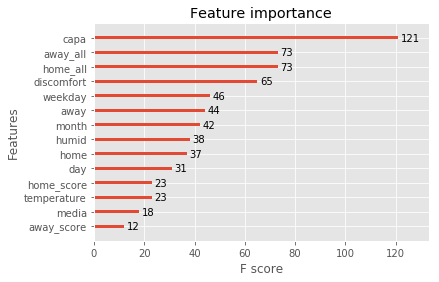

In [55]:
plt.style.use('ggplot')
xgboost.plot_importance(model)

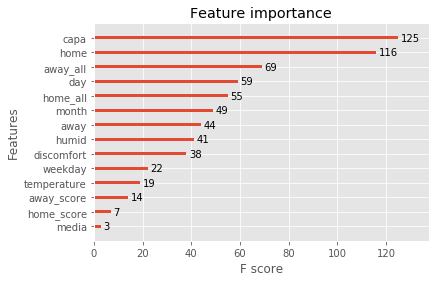

In [56]:
xgboost.plot_importance(model2)

## submit

In [57]:
pred = model.predict(test1)
pred2 = model2.predict(test2)

In [58]:
pred = pd.DataFrame(pred, columns={"pred"})
pred["id"] = j1_id["id"]

In [59]:
pred2 = pd.DataFrame(pred2, columns={"pred"})
pred2["id"] = j2_id["id"]

In [60]:
pred = pd.concat([pred, pred2])

In [61]:
test_id = pd.DataFrame(test_id)
test_id["id"] = test_id

In [62]:
pred = pd.merge(pred, test_id, how="right", on=["id"])

In [63]:
pred = pred.loc[:, ["id", "pred"]]

In [64]:
pred.to_csv("~/repo/study/JLeague/submit/submit_1124_3_xgboost.csv", index=False, header=False)